In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# This is the model we'll be using.
import sklearn.tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus

In [2]:
# Set up all our data in a couple of data frames.
customers = pd.DataFrame()
customers['purchases_amount'] = [105, 65, 89, 99, 149, 102, 34, 120, 129, 39,
                                 20, 30, 109, 40, 55, 100, 23, 20, 70, 10]
customers['purchases_items'] = [1, 4, 5, 4, 7, 1, 2, 10, 6, 5,
                                1, 3, 2, 1, 5, 10, 3, 3, 1, 1]
customers['promo'] = [1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
                      1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
customers['email_list'] = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
                           0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
customers['checkouts'] = [1, 5, 3, 3, 1, 2, 4, 4, 1, 1,
                          1, 1, 2, 4, 1, 1, 2, 1, 1, 1]

repeat_customer = pd.DataFrame()
repeat_customer['repeat'] = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                             0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [3]:
customers.head(3)

,purchases_amount,purchases_items,promo,email_list,checkouts
0,105,1,1,1,1
1,65,4,1,0,5
2,89,5,0,1,3


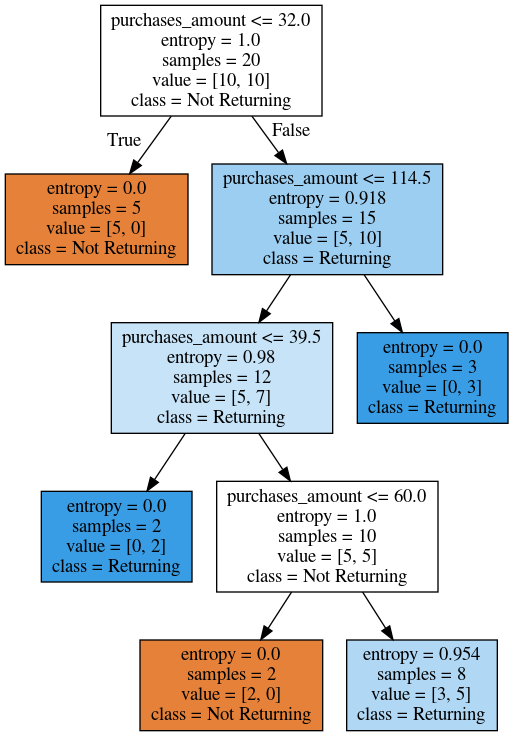

In [4]:
# Initialize and train our tree.
decision_tree = sklearn.tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=4,
)
decision_tree.fit(customers, repeat_customer)

# Render our tree.
dot_data = sklearn.tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=customers.columns,
    class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Calculating Entropy

Since this algorithm is based on entropy let's go over a quick example of how to calculate it.

Let's say we have 20 students, and we're trying to classify them as male and female. The only attribute we have is whether their height is tall, medium, or short. Of the 20 students, 12 are boys with and 8 are girls. Of the 12 boys, 4 are tall, 6 are medium and 2 are short. Of the 8 girls, 1 is tall, 2 are medium, and 5 are short.

What is the entropy, both before any rule is applied and then after applying a rule for being tall?

The initial entropy is just the formula plugged in over both the possible classes of interest:

$$ H = P(male)*log_2 \frac{1}{P(male)} + P(female)*log_2 \frac{1}{P(female)}  $$


$$ = \frac{12}{20}*log_2 \frac{20}{12} + \frac{8}{20}*log_2 \frac{20}{8} = .971 $$

What if we apply the rule _height = short_ ? We need to calculate the weighted average of the two entropies, one for the short students and one for the non-short students.

$$ H(short) = P(male)*log_2 \frac{1}{P(male)} + P(female)*log_2 \frac{1}{P(female)}  $$

$$ = \frac{2}{7}*log_2 \frac{7}{2} + \frac{5}{7}*log_2 \frac{7}{5} = .863 $$

$$ H(not\_short) = P(male)*log_2 \frac{1}{P(male)} + P(female)*log_2 \frac{1}{P(female)}  $$

$$ = \frac{10}{13}*log_2 \frac{13}{10} + \frac{3}{13}*log_2 \frac{13}{3} = .779 $$

Note that all the probabilities here are conditional on the criteria we're assuming (short or not short). Now the weighted average of the two is just:

$$ P(short) * H(short) + P(not\_short) * H(not\_short) = \frac{7}{20} * .863 + \frac{13}{20} * .779 = .809 $$

So our entropy from this question would go from .971 to .809. That's an improvement. Use the space below to calculate the entropy of the other criteria, for we asked whether the students were tall or medium.

In [5]:
from math import log2

# H(tall) = P(male | tall) * log_2(1/P(male | tall)) + P(female | tall) * log_2(1/P(female | tall))
# H(tall) = P(male | not tall) * log_2(1/P(male | not tall)) + P(female | not tall) * log_2(1/P(female | not tall))

H_tall = 4/5 * log2(5/4) + 1/5 * log2(5/1)
H_not_tall = 8/15 * log2(15/8) + 7/15 * log2(15/7)

entropy_tall = (5/20) * H_tall + (15/20) * H_not_tall
entropy_tall

0.9280757477080679

In [6]:
# H(medium) = P(male | medium) * log_2(1/P(male | medium)) + P(female | medium) * log_2(1/P(female | medium))
# H(medium) = P(male | not medium) * log_2(1/P(male | not medium)) + P(female | not medium) * log_2(1/P(female | not medium))

H_medium = 6/8 * log2(8/6) + 2/8 * log2(8/2)
H_not_medium = 6/12 * log2(12/6) + 6/12 * log2(12/6)

entropy_medium = (8/20) * H_medium + (12/20) * H_not_medium
entropy_medium

0.9245112497836531

## We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [7]:
# Get our data.
loans_df = pd.read_csv('/home/uzi/Downloads/LoanStats3d.csv', skipinitialspace=True, header=1)

# Note the warning about dtypes.

/home/uzi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
loans_df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical column and see what happens off of this kind of naive approach.

In [9]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [12]:
rfc = ensemble.RandomForestClassifier()
X = loans_df.drop('loan_status', 1)
Y = loans_df['loan_status']
X = pd.get_dummies(X, sparse=True)

cross_val_score(rfc, X, Y, cv=5)

TypeError: '<' not supported between instances of 'float' and 'str'

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [10]:
categorical = loans_df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i + ' => ' + str(column.nunique()))
    print('-'*20)

id => 421097
--------------------
term => 2
--------------------
int_rate => 110
--------------------
grade => 7
--------------------
sub_grade => 35
--------------------
emp_title => 120812
--------------------
emp_length => 11
--------------------
home_ownership => 4
--------------------
verification_status => 3
--------------------
issue_d => 12
--------------------
loan_status => 7
--------------------
pymnt_plan => 1
--------------------
url => 421095
--------------------
desc => 34
--------------------
purpose => 14
--------------------
title => 27
--------------------
zip_code => 914
--------------------
addr_state => 49
--------------------
earliest_cr_line => 668
--------------------
revol_util => 1211
--------------------
initial_list_status => 2
--------------------
last_pymnt_d => 25
--------------------
next_pymnt_d => 4
--------------------
last_credit_pull_d => 26
--------------------
application_type => 2
--------------------
verification_status_joint => 3
-------------

Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. <font color='blue'>Lets drop the ones with over 30 unique values, converting to numeric where it makes sense.</font> In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [11]:
# Convert ID and Interest Rate to numeric.
loans_df['id'] = pd.to_numeric(loans_df['id'], errors='coerce')
loans_df['int_rate'] = pd.to_numeric(loans_df['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
loans_df.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [12]:
loans_df.tail(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.2,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Removing the last two rows that don't contain any data
loans_df = loans_df.dropna(how='all')

In [14]:
loans_df.tail(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0


In [15]:
pd.get_dummies(loans_df).head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [16]:
# Hide the warnings
warnings.filterwarnings('ignore')

rfc = ensemble.RandomForestClassifier()
X = loans_df.drop('loan_status', 1)
Y = loans_df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [17]:
# Check how long it takes to run
%time score = cross_val_score(rfc, X, Y, cv=10)
print(score)
print(score.mean())

CPU times: user 4min 58s, sys: 4.37 s, total: 5min 2s
Wall time: 3min 39s
[0.97915034 0.98033768 0.98135879 0.98176248 0.97361672 0.97819995
 0.8991902  0.9808592  0.98016957 0.9800266 ]
0.9714671528264148


## DRILL: Third Attempt

So here's your task. **Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation**.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [18]:
Y.unique()

array(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Default', 'Late (16-30 days)'], dtype=object)

In [19]:
from sklearn.decomposition import PCA


# Set our PCA to keep as many components required to explain 99.9% of the variance
pca = PCA(n_components=0.999)
pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.99842296, 0.00122397])

### We can see that only two components are needed to explain 99.9% of the variance

In [20]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.999) + 1
d

2

### With 'd' being the number of components needed to cumulatively sum up to 99.9% of the variance, again, we see the same result.

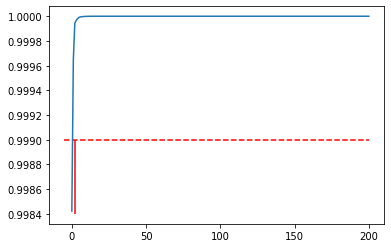

In [21]:
# We can plot the explained variance to see this visually
plt.plot(cumsum)
plt.hlines(y=.999, xmin=-5, xmax=200, linestyle='--', color='r')
plt.vlines(x=d, ymin=.9984, ymax=.999, color='r')
plt.show()

In [22]:
# We turn the target variable into numerics so that we can calculate correlations
loans_df['loan_status_num'] = loans_df['loan_status'].astype('category').cat.codes

In [23]:
# Print the correlation values for all the features relative to the target variable and
# that meet a certain threshold

corrs = loans_df.corr()['loan_status_num']
for i, value in enumerate(corrs):
    # I chose .2 somewhat arbitrarily after looking at the correlation values
    if np.abs(value) >= .2:
        print(corrs.index[i] + ' ' + str(value))

out_prncp -0.2185537482440826
out_prncp_inv -0.21859521434887624
total_pymnt 0.3469319436865928
total_pymnt_inv 0.34691410300840614
total_rec_prncp 0.4117886697874974
last_pymnt_amnt 0.4929875399609807
loan_status_num 1.0


In [24]:
# We create a new df with only the 'high' correlation features
X_revised = loans_df[['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','last_pymnt_amnt']]

In [25]:
# We run PCA to see how much of the variance the revised features explain...
pca = PCA()
pca.fit(X_revised)
pca.explained_variance_ratio_

array([5.81249691e-01, 3.88198922e-01, 2.68968973e-02, 3.65335069e-03,
       9.12215465e-07, 2.26807292e-07])

In [26]:
# ... and how many components are necessary to explain 99.9% of the variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.999) + 1
d

4

In [27]:
# Check how long it takes to run (all 6 variables considered)
%time score = cross_val_score(rfc, X_revised, Y, cv=10)
print(score)
print(score.mean())

CPU times: user 3min 14s, sys: 977 ms, total: 3min 15s
Wall time: 2min 4s
[0.7930232  0.95877562 0.94227162 0.95224526 0.9493232  0.94065543
 0.90885559 0.923888   0.94492602 0.95955446]
0.9273518390496346


In [28]:
# Check how long it takes to run (4 principal components considered)
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X_revised)

%time score = cross_val_score(rfc, X_reduced, Y, cv=10)
print(score)
print(score.mean())

CPU times: user 3min 41s, sys: 777 ms, total: 3min 42s
Wall time: 2min 30s
[0.78502054 0.95989171 0.95274394 0.9526727  0.94896699 0.93949181
 0.90541214 0.92395925 0.94112618 0.95755949]
0.9266844755616411


# Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [29]:
prncp_cols = [col for col in loans_df.columns if 'prncp' in col]
print(prncp_cols)

['out_prncp', 'out_prncp_inv', 'total_rec_prncp']


In [30]:
pymnt_cols = [col for col in loans_df.columns if 'pymnt' in col]
print(pymnt_cols)

['pymnt_plan', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d']


In [31]:
# Drop the outstanding priciple and payment amount features, as well as the id features
X = loans_df.drop(['loan_status','out_prncp', 'out_prncp_inv','total_pymnt', 
                   'total_pymnt_inv','last_pymnt_amnt','member_id', 'id'], 1)
Y = loans_df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [42]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.84028231, 0.06918258, 0.04388149])

In [43]:
# Check how long it takes to run
%time score = cross_val_score(rfc, X_reduced, Y, cv=10)
print(score)
print(score.mean())

CPU times: user 3min 13s, sys: 1.05 s, total: 3min 14s
Wall time: 2min 1s
[0.64047399 0.64071145 0.63947662 0.64052148 0.64167656 0.6395393
 0.63943575 0.63867582 0.64089106 0.64074004]
0.6402142069849603


## How do we tell which features are the most important for each principle component?

In [44]:
# number of components to satisfy the previously determined threshold
n_pcs = pca.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

most_important_names = [X.columns[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [65]:
print(n_pcs)
print(most_important)
print(most_important_names)

3
[47, 5, 48]
['tot_hi_cred_lim', 'annual_inc', 'total_bal_ex_mort']


In [49]:
df

,0,1
0,PC0,tot_hi_cred_lim
1,PC1,annual_inc
2,PC2,total_bal_ex_mort


> With the id features you can score 90%+ even with out the payment and principle features. Without the id features it doesn't seem possible.